In [ ]:
!pip install fastdtw


In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import re

# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')


# Path to the labels file
labels_dir = '/content/drive/My Drive/Andrew/School/Grad School/Coursework/24-25/ENME691/Final/Train/labels02.xlsx'
labels_df = pd.read_excel(labels_dir)

# Directory containing the training data CSV files
train_dir = '/content/drive/My Drive/Andrew/School/Grad School/Coursework/24-25/ENME691/Final/Train/data'
test_dir = '/content/drive/My Drive/Andrew/School/Grad School/Coursework/24-25/ENME691/Final/Test/data'
test_labels_dir = '/content/drive/My Drive/Andrew/School/Grad School/Coursework/24-25/ENME691/Final/Test/answer.xlsx'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Classification for Known and Unkown Status

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib.pyplot as plt
import re

# Step 1: Load training and test data
train_dir = '/content/drive/My Drive/Andrew/School/Grad School/Coursework/24-25/ENME691/Final/Train/data'
test_dir = '/content/drive/My Drive/Andrew/School/Grad School/Coursework/24-25/ENME691/Final/Test/data'
label_path = '/content/drive/My Drive/Andrew/School/Grad School/Coursework/24-25/ENME691/Final/Train/labels.xlsx'

# Load all training files into a dictionary
train_data = {}
for file in os.listdir(train_dir):
    if file.endswith('.csv'):
        file_path = os.path.join(train_dir, file)
        df = pd.read_csv(file_path)
        train_data[file.replace('.csv', '')] = df

# Load all test files into a dictionary
test_data = {}
for file in os.listdir(test_dir):
    if file.endswith('.csv'):
        file_path = os.path.join(test_dir, file)
        df = pd.read_csv(file_path)
        test_data[file.replace('.csv', '')] = df

# Load labels from Excel
labels_df = pd.read_excel(label_path)
labels_df = labels_df.dropna(subset=['Case#', 'Condition']).copy()
labels_df['Case#'] = labels_df['Case#'].astype(int)
labels_map = dict(zip(labels_df['Case#'], labels_df['Condition']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Visualization of the test cases w.r.t the Thresholds calculated

In [ ]:
import pandas as pd

alpha = 0.1
beta = 30

# Step 3: Compare test data with training data using DTW for all sensors
results = []

for test_key, test_df in test_data.items():
    min_distance = float('inf')
    closest_train_file = None

    # Extract data for all sensors (P1 to P7) for the first 0.1 seconds in the test file
    test_values = test_df[test_df['TIME'] <= 0.1][['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']].values

    for train_key, train_df in train_data.items():
        # Extract data for all sensors (P1 to P7) for the first 0.1 seconds in the training file
        train_values = train_df[train_df['TIME'] <= 0.1][['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']].values
        # Compute DTW distance for multi-dimensional data
        distance, _ = fastdtw(test_values, train_values, dist=euclidean)
        # Track the closest match
        if distance < min_distance:
            min_distance = distance
            closest_train_file = train_key

    # Classify based on thresholds
    if min_distance < alpha:
        case_number = int(re.search(r'\d+', closest_train_file).group())
        fault_locations = fault_location_map.get(case_number, {})
        fault_columns = [
            col for col, value in fault_locations.items() if str(value).strip().lower() == "yes"
        ]
        classification = ", ".join(fault_columns) if fault_columns else "Healthy"
    elif alpha <= min_distance < beta:
        classification = "SV"
    else:
        classification = "Unknown"

    # Add results to the list
    results.append({
        "Test Case": test_key,
        "Closest Train File": closest_train_file,
        "DTW Distance": min_distance,
        "Classification": classification
    })

# Step 4: Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the DataFrame by Test Case in ascending order
results_df['Test Case Number'] = results_df['Test Case'].str.extract(r'(\d+)').astype(int)  # Extract case number
results_df = results_df.sort_values(by='Test Case Number').drop(columns=['Test Case Number'])

# Print the DataFrame
print("\nResults:")
print(results_df.to_string(index=False))



Results:
Test Case Closest Train File  DTW Distance Classification
  Case178            Case155      0.000000            BP2
  Case179            Case111      1.205294             SV
  Case180            Case002      0.000000        Healthy
  Case181            Case121      0.645203             SV
  Case182            Case002      0.000000        Healthy
  Case183            Case002      0.000000        Healthy
  Case184            Case106    232.859588        Unknown
  Case185            Case002      0.000000        Healthy
  Case186            Case159      0.000000            BP6
  Case187            Case002      0.000000        Healthy
  Case188            Case107     11.292175             SV
  Case189            Case002      0.000000        Healthy
  Case190            Case116      1.605716             SV
  Case191            Case002      0.000000        Healthy
  Case192            Case114    227.026346        Unknown
  Case193            Case154      0.000000            BP1
  Ca

In [ ]:
coefficients = [1.39028959e+01, -4.10009461e+01, 5.16300316e+01, 1.11155994e+01, -2.86120445e-02]


In [ ]:
# Function for polynomial fit
def polynomial_fit(x, coeffs):
    """
    Evaluate the polynomial given the input x (pressure drop) and the coefficients in correct order (highest exponent first).
    """
    return sum(c * x**(len(coeffs)-1-i) for i, c in enumerate(coeffs))

# Create a copy of the results_df to modify
updated_results_df = results_df.copy()

# Add a new column for the estimated valve open ratio
updated_results_df['Estimated Valve Open Ratio (%)'] = 100  # Default to 100% for non-SV cases

# Process only the SV classified cases
for i, row in updated_results_df.iterrows():
    if row['Classification'] == 'SV':
        test_case = row['Test Case']
        test_file = os.path.join(test_dir, f"{test_case}.csv")

        # Load test data
        test_data = pd.read_csv(test_file)

        # Check column names
        if 'Time' in test_data.columns:
            time_series = test_data['Time'].values
        else:
            time_series = np.arange(len(test_data))  # Default to indices if no time column

        # Extract pressure columns for solenoids
        pressures = test_data[['P3', 'P4', 'P6', 'P7']].iloc[0].values

        # Calculate pressure drops
        pressure_drops = []
        for sensor in ['P3', 'P4', 'P6', 'P7']:
            initial_pressure = 2  # The initial pressure (defined in problem)
            pressure_series = test_data[sensor].values
            # Find the first value after initial pressure drop that is above a threshold
            drop_indices = np.where(pressure_series < initial_pressure - 1e-10)[0]
            if drop_indices.size > 0:
                pressure_drop = initial_pressure - pressure_series[drop_indices[0]]
            else:
                pressure_drop = 0  # If no drop occurs, set drop to 0

            pressure_drops.append(pressure_drop)

        # Identify solenoid with minimum pressure drop
        min_pressure_drop = min(pressure_drops)
        min_pressure_drop_index = np.argmin(pressure_drops)

        # Map solenoid location based on index
        solenoid_mapping = {0: 'SV1', 1: 'SV2', 2: 'SV3', 3: 'SV4'}
        solenoid_location = solenoid_mapping[min_pressure_drop_index]

        # Estimate valve open ratio
        estimated_ratio = polynomial_fit(min_pressure_drop, coefficients)
        # Update updated_results_df
        updated_results_df.at[i, 'Classification'] = solenoid_location
        updated_results_df.at[i, 'Estimated Valve Open Ratio (%)'] = estimated_ratio

# Save or print the final updated results
print("\nUpdated Results:")
print(updated_results_df.to_string(index=False))



Updated Results:
Test Case Closest Train File  DTW Distance Classification  Estimated Valve Open Ratio (%)
  Case178            Case155      0.000000            BP2                      100.000000
  Case179            Case111      1.205294            SV2                       21.978487
  Case180            Case002      0.000000        Healthy                      100.000000
  Case181            Case121      0.645203            SV4                       76.943052
  Case182            Case002      0.000000        Healthy                      100.000000
  Case183            Case002      0.000000        Healthy                      100.000000
  Case184            Case106    232.859588        Unknown                      100.000000
  Case185            Case002      0.000000        Healthy                      100.000000
  Case186            Case159      0.000000            BP6                      100.000000
  Case187            Case002      0.000000        Healthy                      100

<ipython-input-60-f2b3ff0f1bca>:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.978486985276813' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  updated_results_df.at[i, 'Estimated Valve Open Ratio (%)'] = estimated_ratio


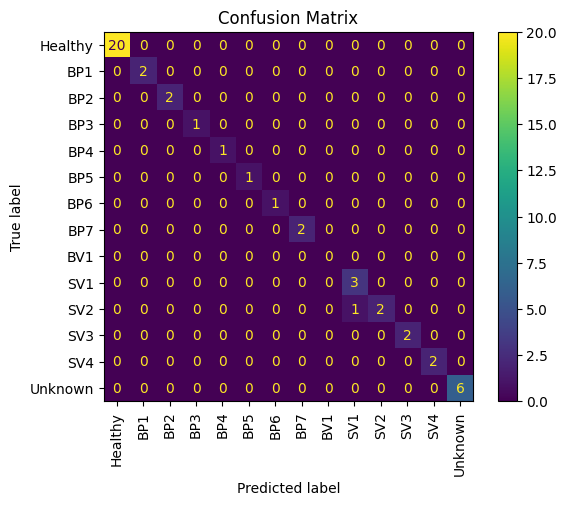

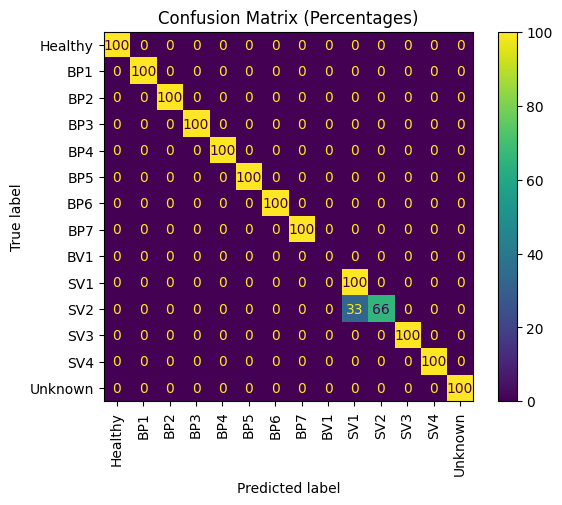

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# Load the ground truth answers
test_labels_dir = '/content/drive/My Drive/Andrew/School/Grad School/Coursework/24-25/ENME691/Final/Test/answer.csv'
ground_truth_df = pd.read_csv(test_labels_dir)

# Add the Test condition column directly to updated_results_df
updated_results_df['Classification_Actual'] = ground_truth_df['Test condition']

# Standardize the ground truth labels to match prediction format
updated_results_df['Classification_Actual'] = updated_results_df['Classification_Actual'].replace({
    'BP1 bubble anomaly': 'BP1',
    'BP2 bubble anomaly': 'BP2',
    'BP3 bubble anomaly': 'BP3',
    'BP4 bubble anomaly': 'BP4',
    'BP5 bubble anomaly': 'BP5',
    'BP6 bubble anomaly': 'BP6',
    'BP7 bubble anomaly': 'BP7',
    'BV1 bubble anomaly': 'BV1',
    'SV1 valve fault': 'SV1',
    'SV2 valve fault': 'SV2',
    'SV3 valve fault': 'SV3',
    'SV4 valve fault': 'SV4',
    'Unknown anomaly': 'Unknown',
    'Normal': 'Healthy'  # Map Normal to Healthy
})

# Extract predicted and actual labels
y_pred = updated_results_df['Classification']
y_true = updated_results_df['Classification_Actual']

# Generate confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [
    'Healthy', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7',
    'BV1', 'SV1', 'SV2', 'SV3', 'SV4', 'Unknown'
]

cm1 = confusion_matrix(y_true, y_pred, labels=labels)
cm2 = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')

# Truncate decimals by multiplying by 100, converting to integers, then dividing by 100
cm2 = np.trunc(cm2 * 100).astype(int)  # Convert to integers representing percentages

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')
plt.title("Confusion Matrix")
plt.show()


# Display confusion matrix with integer percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')  # Display integers
plt.title("Confusion Matrix (Percentages)")
plt.show()

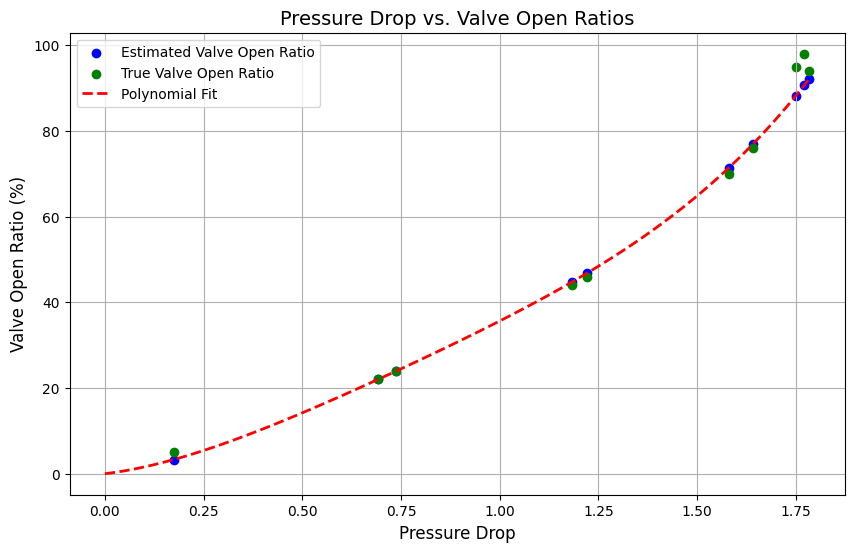

In [ ]:
# Generate the polynomial curve for plotting
pressure_drop_range = np.linspace(0, max(updated_results_df['Pressure Drop']), 100)
fitted_ratios = [polynomial_fit(x, coefficients) for x in pressure_drop_range]

# Filter for SV faults (SV1 to SV4)
sv_faults = updated_results_df[updated_results_df['Classification'].isin(['SV1', 'SV2', 'SV3', 'SV4'])]

# Plot Pressure Drop vs. Estimated and True Valve Open Ratios
plt.figure(figsize=(10, 6))

# Scatter plot for Estimated Valve Open Ratio
plt.scatter(
    sv_faults['Pressure Drop'],
    sv_faults['Estimated Valve Open Ratio (%)'],
    color='blue',
    label='Estimated Valve Open Ratio'
)

# Scatter plot for True Valve Open Ratio
plt.scatter(
    sv_faults['Pressure Drop'],
    sv_faults['True Valve Open Ratio (%)'],
    color='green',
    label='True Valve Open Ratio'
)

# Polynomial fit curve
plt.plot(
    pressure_drop_range,
    fitted_ratios,
    color='red',
    linestyle='--',
    linewidth=2,
    label='Polynomial Fit'
)

# Plot configuration
plt.title('Pressure Drop vs. Valve Open Ratios', fontsize=14)
plt.xlabel('Pressure Drop', fontsize=12)
plt.ylabel('Valve Open Ratio (%)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


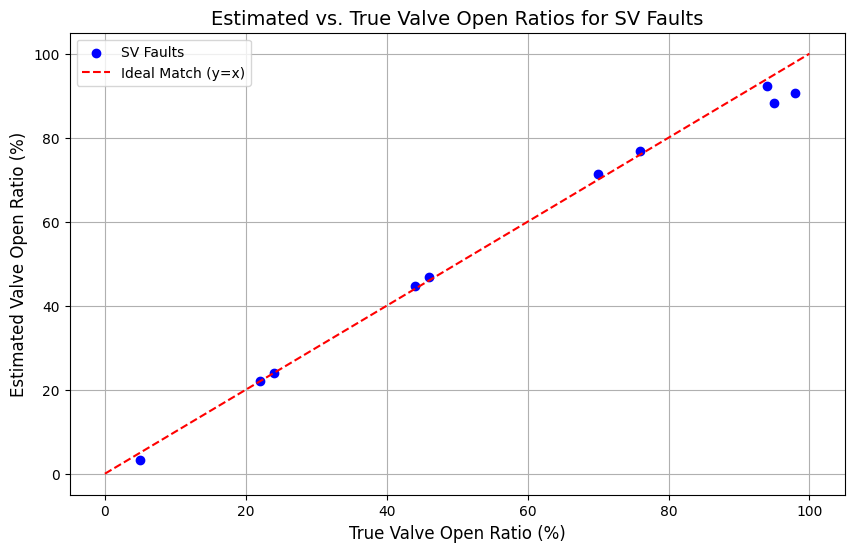

In [ ]:
import matplotlib.pyplot as plt

# Add the true valve open ratio (Task5) column to updated_results_df
updated_results_df['True Valve Open Ratio (%)'] = ground_truth_df['task5']

# Filter rows corresponding to SV faults (SV1 to SV4)
sv_faults = updated_results_df[updated_results_df['Classification'].isin(['SV1', 'SV2', 'SV3', 'SV4'])]

# Plot the estimated vs. true valve open ratios for SV faults
plt.figure(figsize=(10, 6))
plt.scatter(sv_faults['True Valve Open Ratio (%)'], sv_faults['Estimated Valve Open Ratio (%)'], color='blue', label='SV Faults')
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='Ideal Match (y=x)')
plt.title('Estimated vs. True Valve Open Ratios for SV Faults', fontsize=14)
plt.xlabel('True Valve Open Ratio (%)', fontsize=12)
plt.ylabel('Estimated Valve Open Ratio (%)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Add a new column for pressure drop and estimated valve open ratio
updated_results_df['Pressure Drop'] = 0  # Default value for non-SV cases
updated_results_df['True Valve Open Ratio (%)'] = ground_truth_df['task5']

# Process only the SV classified cases
for i, row in updated_results_df.iterrows():
    if row['Classification'] in ['SV1', 'SV2', 'SV3', 'SV4']:
        test_case = row['Test Case']
        test_file = os.path.join(test_dir, f"{test_case}.csv")

        # Load test data
        test_data = pd.read_csv(test_file)

        # Extract pressure columns for solenoids
        pressure_drops = []
        for sensor in ['P3', 'P4', 'P6', 'P7']:
            initial_pressure = 2  # The initial pressure (defined in problem)
            pressure_series = test_data[sensor].values

            # Find the first value after initial pressure drop that is above a threshold
            drop_indices = np.where(pressure_series < initial_pressure - 1e-10)[0]
            if drop_indices.size > 0:
                pressure_drop = initial_pressure - pressure_series[drop_indices[0]]
            else:
                pressure_drop = 0  # If no drop occurs, set drop to 0

            pressure_drops.append(pressure_drop)

        # Identify solenoid with minimum pressure drop
        min_pressure_drop = min(pressure_drops)

        # Update the pressure drop and estimated valve open ratio
        updated_results_df.at[i, 'Pressure Drop'] = min_pressure_drop
        updated_results_df.at[i, 'Estimated Valve Open Ratio (%)'] = polynomial_fit(min_pressure_drop, coefficients)


<ipython-input-95-d5b6c206062c>:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6917600875388197' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  updated_results_df.at[i, 'Pressure Drop'] = min_pressure_drop


In [ ]:
# Reorder columns and drop the rest
updated_results_df = updated_results_df[[
    'Test Case',
    'Classification',
    'Classification_Actual',
    'Closest Train File',
    'DTW Distance',
    'Pressure Drop',
    'Estimated Valve Open Ratio (%)',
    'True Valve Open Ratio (%)'
]]

# Display the reordered DataFrame
print("\nReordered DataFrame:")
print(updated_results_df.to_string(index=False))




Reordered DataFrame:
Test Case Classification Classification_Actual Closest Train File  DTW Distance  Pressure Drop  Estimated Valve Open Ratio (%)  True Valve Open Ratio (%)
  Case178            BP2                   BP2            Case155      0.000000       0.000000                      100.000000                        100
  Case179            SV2                   SV2            Case111      1.205294       0.691760                       21.978487                         22
  Case180        Healthy               Healthy            Case002      0.000000       0.000000                      100.000000                        100
  Case181            SV4                   SV4            Case121      0.645203       1.641662                       76.943052                         76
  Case182        Healthy               Healthy            Case002      0.000000       0.000000                      100.000000                        100
  Case183        Healthy               Healthy        